In [102]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [103]:
# Загрузка данных
data = pd.read_csv("input/data.csv", delimiter=";")
data.head()

,Год,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,1998,65120.0,328497.9,401044,120334,803.2,4767.0,1212184,33.8,10427.0,10759.00000,6171.0,6642.0,111458,1393.30
1,1999,93800.0,695059.8,577671,173332,787.6,4962.0,1272744,35.2,17310.0,17861.00000,7260.0,7814.0,185861,1807.80
2,2000,156215.0,1159034.0,962057,289037,1472.8,5277.0,1444737,32.4,24927.0,25720.20000,8067.0,9194.0,309534,2185.00
3,2001,173839.0,1370182.8,1257513,351188,1154.6,5712.2,1841258,30.4,33701.0,34773.39673,5545.0,12637.0,418289,2385.26
4,2002,220396.0,1767476.7,1544402,380535,1508.7,5832.4,2255912,35.1,46034.0,25688.00000,6932.0,13817.0,589139,2918.55


### Объяснение переменных
- $y_1$ - инвестиции в основной капитал, млн руб.
- $y_2$ - валовой региональный продукт (ВРП), млн.руб.
- $y_3$ - сумма доходов населения за год, млн руб.
- $x_1$ - финансовый результат деятельности (чистая прибыль)
- $x_2$ - прямые иностранные инвестиции, млн USD
- $x_3$ - среднегодовая численности занятых, тыс чел.
- $x_4$ - стоимость основных фондов, млн. руб
- $x_5$ - степень износа основных фондов, %
- $x_6$ - затраты на научные исследования и разработки, млн руб.
- $x_7$ - объём инновационных товаров работ услуг, млн руб.
- $x_8$ - экспорт, млн USD
- $x_9$ - импорт, млн. USD
- $x_{10}$ - сумма остатков вкладов на счетах в Банке России, млн. руб.
- $x_{11}$ - прожиточный минимум в регионе РФ (г. Москва), тыс.руб.

In [58]:
# data.columns = ['Год', 'инвестиции в основной капитал', 'валовой региональный продукт', 'сумма доходов населения за год', 'финансовый результат деятельности', 'прямые иностранные инвестиции', 'среднегодовая численности занятых', 'стоимость основных фондов', 'степень износа основных фондов', 'затраты на научные исследования и разработки', 'объём инновационных товаров работ услуг', 'экспорт', 'импорт', 'сумма остатков вкладов на счетах в Банке России', 'прожиточный минимум в регионе РФ']

### Системы уравнений

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon \\
y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon \\
\end{cases}
$$

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \\
y_3 = \\
\end{cases}
$$

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \\
y_3 = \\
\end{cases}
$$

#### Альтернативная система
$$ВРП = Y_1 + Y_ 2+ Y_3 + Y_4 + Y_5$$

$$
\begin{cases}
Y_{\text{1-Внутренний сектор}} = Y_{\text{4-Факторы предложения}} + Y_{\text{2-Внешний сектор}} + Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{2-Внешний сектор}} = Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{3-Бюджетная система}} = Y_{\text{1-Внутренний сектор}} + Y_{\text{4-Факторы предложения}} + Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{4-Факторы предложения}} = Y_{\text{1-Внутренний сектор}} + Y_{\text{2-Внешний сектор}} + Y_{\text{3-Бюджетная система}} + x{\dots}\\

Y_{\text{5-Экзогенные переменные}} = x{\dots}\\
\end{cases}
$$

<Axes: >

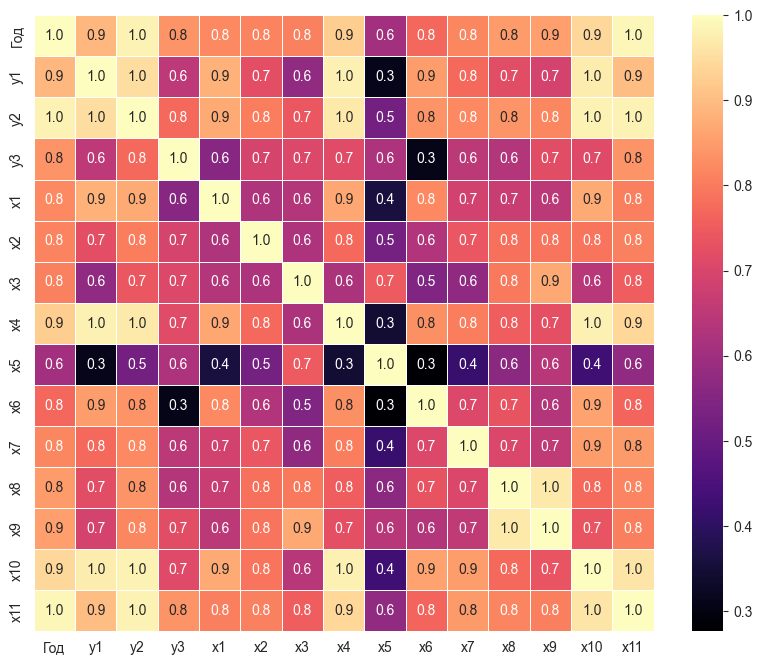

In [105]:
# Матрица коэффициентов межфакторной корреляции
fig, ax = plt.subplots(figsize=(10, 8))

# data.corr()

# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5)
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='crest')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='cubehelix')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='vlag')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='icefire')
sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

# Избавляемся от выбросов

In [106]:
data.shape

(25, 15)

**Z-оценка**

In [108]:
z = np.abs(stats.zscore(data))
data_clean = data[(z<3).all(axis=1)]
data_clean.shape

(24, 15)

**Межквартильный размах (IQR)**

In [110]:
#find Q1, Q3, and interquartile range for each column
Q1 = data.quantile(q=.25)
Q3 = data.quantile(q=.75)
IQR = data.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5\*IQR of Q1 and Q3
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_clean.shape  # без 20,21,22 годов

(22, 15)

In [111]:
data = data_clean

# Отбор переменных

In [112]:
data.head()

,Год,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,1998,65120.0,328497.9,401044,120334,803.2,4767.0,1212184,33.8,10427.0,10759.00000,6171.0,6642.0,111458,1393.30
1,1999,93800.0,695059.8,577671,173332,787.6,4962.0,1272744,35.2,17310.0,17861.00000,7260.0,7814.0,185861,1807.80
2,2000,156215.0,1159034.0,962057,289037,1472.8,5277.0,1444737,32.4,24927.0,25720.20000,8067.0,9194.0,309534,2185.00
3,2001,173839.0,1370182.8,1257513,351188,1154.6,5712.2,1841258,30.4,33701.0,34773.39673,5545.0,12637.0,418289,2385.26
4,2002,220396.0,1767476.7,1544402,380535,1508.7,5832.4,2255912,35.1,46034.0,25688.00000,6932.0,13817.0,589139,2918.55


In [65]:
y = data[['y1', 'y2', 'y3']]
y1 = y['y1']
y2 = y['y2']
y3 = y['y3']

In [66]:
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']]
x1 = X['x1']
x2 = X['x2']
x3 = X['x3']
x4 = X['x4']
x5 = X['x5']
x6 = X['x6']
x7 = X['x7']
x8 = X['x8']
x9 = X['x9']
x10 = X['x10']
x11 = X['x11']

In [116]:
class CustomLinearRegression():
    def __init__(self, y, x):
        self.y = y
        self.x = x
        x = sm.add_constant(x)
        self.model = sm.OLS(y, x).fit()

    def summary(self):
        print(self.model.summary())

    def pre(self):
        return self.model.predict(self.x)

    def F(self):
        return self.model.fvalue

    def p(self):
        return self.model.f_pvalue

    def current_p(self, i):
        return self.model.pvalues[i]

    def R2(self):
        return self.model.rsquared

    def R2_adj(self):
        return self.model.rsquared_adj

    def t(self):
        return self.model.tvalues

    def forward_selection(self):
        xi = []
        x_new = []  # список переменных, которые будут включены в модель
        x_len = len(self.x.columns)  # количество столбцов в датафрейме
        for n in range(x_len):
            F_max = 0  # максимальное значение F
            F_max_i = 0
            F_max_x = ''
            for i in range(x_len):
                if i not in xi:
                    x_test = x_new.copy()
                    x_test.append(self.x.columns[i])
                    F = CustomLinearRegression(self.y, self.x.loc[:, x_test]).F()
                    print(f"'x{i + 1}',", F)
                    if F > F_max:
                        for j in range(len(x_test)):
                            p = CustomLinearRegression(self.y, self.x.loc[:, x_test]).current_p(j)
                            if p > 0.05:
                                break
                        F_max = F
                        F_max_i = i
                        F_max_x = f"x{i + 1}"
            x_new.append(F_max_x)
            xi.append(F_max_i)
            print(x_new)
        CustomLinearRegression(self.y, self.x.loc[:, x_new]).summary()

    def backward_elimination(self):
        n = 0
        p_max = 0
        p_max_i = 0
        x_new = self.x.copy()
        x_len = len(self.x.columns)
        for n in range(x_len):
            p_max = 0
            for i in range(x_len - n):
                p = CustomLinearRegression(self.y, x_new).current_p(i)
                if p > 0.05:
                    if p > p_max:
                        p_max = p
                        p_max_i = i
                    x_new.drop(x_new.columns[p_max_i], axis=1, inplace=True)
                    n += 1
        print(x_new)

    def correlation_map(self):
        return sns.heatmap(self.x.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

## Оценка ранее предложенный систем уравнений
## Система независимых уравнений (Вариант 1)
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon \\
y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon \\
\end{cases}
$$

### Первое уравнение
$$y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon$$

#### Исходное уравнение

In [94]:
fn1 = pd.concat([x1, x2], axis=1)
CustomLinearRegression(y1, fn1).summary()

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     26.69
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           3.03e-06
Time:                        20:47:12   Log-Likelihood:                -316.23
No. Observations:                  22   AIC:                             638.5
Df Residuals:                      19   BIC:                             641.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.955e+04   1.62e+05      0.368      0.7

### Второе уравнение
$$y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon$$

#### Исходное уравнение

In [74]:
fn2 = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, -x9], axis=1)
CustomLinearRegression(y2, fn2).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              338.6
Date:                Wed, 05 Apr 2023   Prob (F-statistic):                    6.30e-14
Time:                        20:30:38   Log-Likelihood:                         -325.95
No. Observations:                  22   AIC:                                      669.9
Df Residuals:                      13   BIC:                                      679.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходное уравнение с исключением статистически незначимых параметров

In [117]:
# Методом прямого включения
# CustomLinearRegression(y2, X).forward_selection()

# Методом обратного исключения
CustomLinearRegression(y2, X).backward_elimination()

IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:
CustomLinearRegression(y2, X['x6']).summary()

### Третье уравнение
$$y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon$$

#### Исходное уравнение

In [101]:
fn3 = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11], axis=1)
CustomLinearRegression(y3, fn3).summary()

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     309.4
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           3.85e-11
Time:                        20:54:00   Log-Likelihood:                -298.00
No. Observations:                  22   AIC:                             620.0
Df Residuals:                      10   BIC:                             633.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.004e+06   9.85e+05     -2.035      0.0

#### Исходное уравнение с исключением статистически незначимых параметров